# Income Classification

Original Dataset: https://archive.ics.uci.edu/ml/datasets/adult

# TODO
Welche Kategorien haben aussagekräftige Verteilungen?
Boxplots nach Zielgröße und Kategorien

### Imports

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from matplotlib.patches import Patch
import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score




## Preparation

### Load data

In [2]:
train_df = pd.read_csv('adult.data', delimiter=',', skipinitialspace=True, na_values=['?'])
test_df = pd.read_csv('adult.test', delimiter=',', skipinitialspace=True, na_values=['?'])

train_df_size = train_df.shape[0]
test_df_size = test_df.shape[0]
df_size = train_df_size + test_df_size

print(f'Train Dataset Size: {train_df_size} ({(train_df_size/df_size):.2%})')
print(f'Test Dataset Size: {test_df_size} ({(test_df_size/df_size):.2%})')

Train Dataset Size: 32561 (66.67%)
Test Dataset Size: 16281 (33.33%)


### Pre Processing

First we need to label the data with ones for income >50k and zeros for income <=50k.

In [3]:
train_df['income'] = train_df['income'].apply(lambda x: 1 if x == '>50K' else 0)
test_df['income'] = test_df['income'].apply(lambda x: 1 if x == '>50K.' else 0)

**education** is encoded in **education-num** with numbe from 1 to 16. We can also drop this variable, because the information is useless.

In [4]:
train_df = train_df.drop('education-num',axis= 1)
test_df = test_df.drop("education-num", axis = 1)

### Dataset Info

The dataset contains 9 character variables and 6 numerical variables.
**income** is the target variable.

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   marital-status  32561 non-null  object
 5   occupation      30718 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   capital-gain    32561 non-null  int64 
 10  capital-loss    32561 non-null  int64 
 11  hours-per-week  32561 non-null  int64 
 12  native-country  31978 non-null  object
 13  income          32561 non-null  int64 
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


### Dataset statistics

### Check missing values and fill it with most recent values

In [6]:
train_df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

In [7]:
train_df['workclass'].fillna(train_df['workclass'].mode()[0], inplace=True)
train_df['occupation'].fillna(train_df['occupation'].mode()[0], inplace=True)
train_df['native-country'].fillna(train_df['native-country'].mode()[0], inplace=True)   

test_df['workclass'].fillna(train_df['workclass'].mode()[0], inplace=True)
test_df['occupation'].fillna(train_df['occupation'].mode()[0], inplace=True)
test_df['native-country'].fillna(train_df['native-country'].mode()[0], inplace=True)   

In [8]:
train_df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

## Numeric

In [9]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
capital-gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital-loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours-per-week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0
income,32561.0,0.240810,0.427581,0.0,0.0,0.0,0.0,1.0


## Variables

In [10]:
categorical = [var for var in train_df.columns if train_df[var].dtype==object]
numeric = [var for var in train_df.columns if train_df[var].dtype!=object]
numeric.remove("income")

print('There are {} categorical variables:\n'.format(len(categorical)))

for var in categorical:

    print(f'{var} contains {len(train_df[var].unique())} labels')

print('\nThere are {} numeric variables:\n\n{}'.format(len(numeric), numeric))

There are 8 categorical variables:

workclass contains 8 labels
education contains 16 labels
marital-status contains 7 labels
occupation contains 14 labels
relationship contains 6 labels
race contains 5 labels
sex contains 2 labels
native-country contains 41 labels

There are 5 numeric variables:

['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']


# Charts

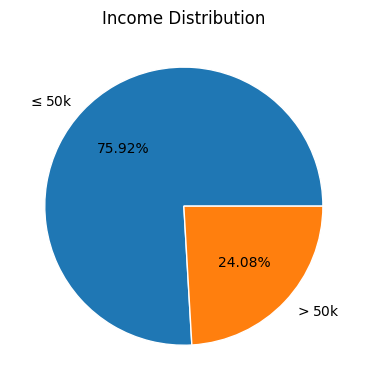

In [11]:
plt.figure(figsize=(4,4))
train_df['income'].value_counts().plot.pie(labels=[r'$\leq50$k', r'$>50$k'], autopct='%1.2f%%', wedgeprops = {"linewidth": 1, "edgecolor": "white"})
plt.title('Income Distribution')
plt.tight_layout()
plt.ylabel('')
plt.show()

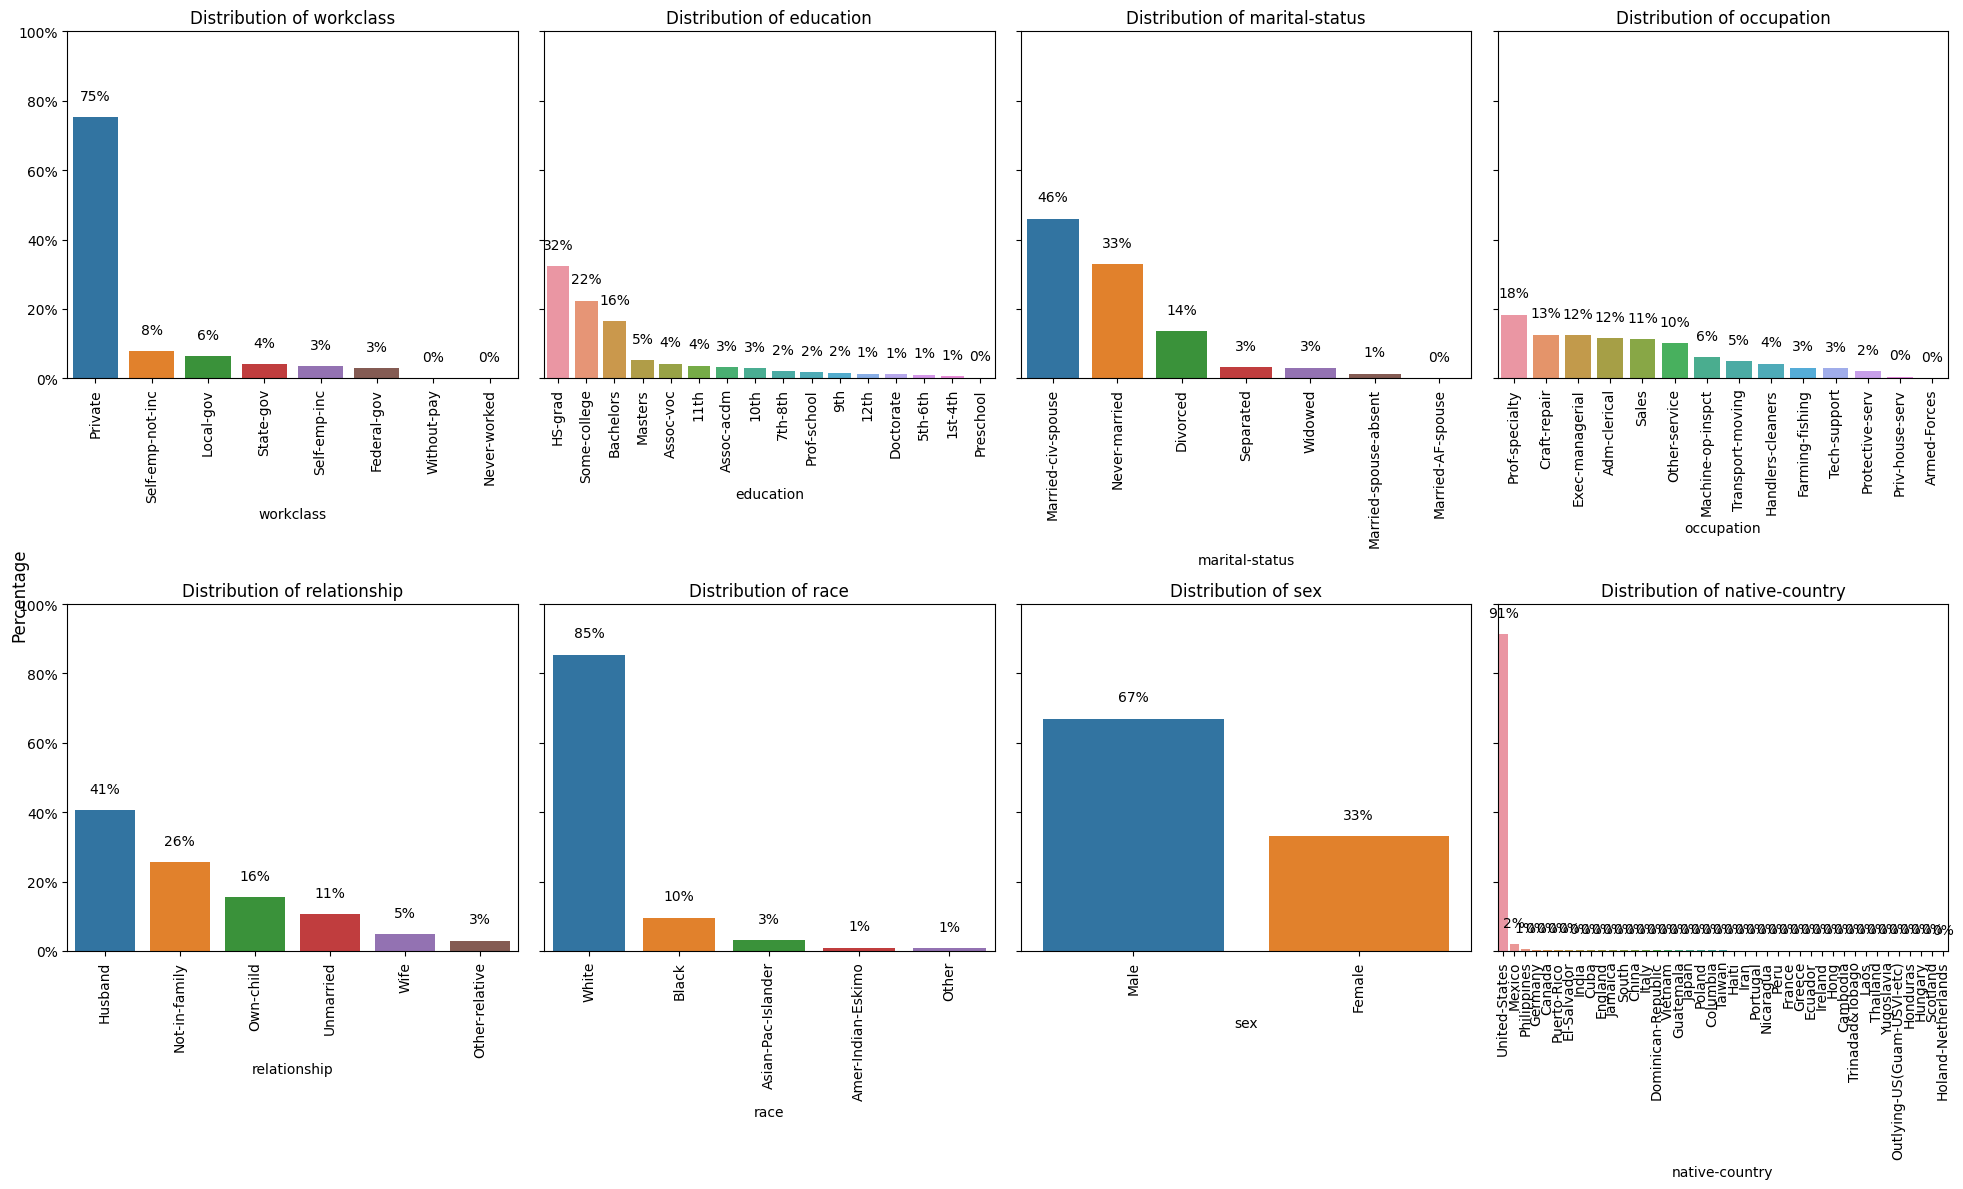

In [12]:
rows=2
cols=4

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols, 6*rows), sharey=True)
fig.supylabel('Percentage')

for i, variable in enumerate(categorical):
    row = i // cols
    col = i % cols
    ax = axes[row][col]
    pct_counts = train_df[variable].value_counts(normalize=True)
    sns.barplot(x=pct_counts.index, y=pct_counts.values, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    yticks = mtick.PercentFormatter(1)
    ax.yaxis.set_major_formatter(yticks)
    ax.set_ylim([0, 1])
    ax.set_title('Distribution of {}'.format(variable))

    for j, p in enumerate(ax.patches):
        ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.05, '{:.0%}'.format(pct_counts.values[j]), ha='center')

plt.tight_layout()
plt.show()

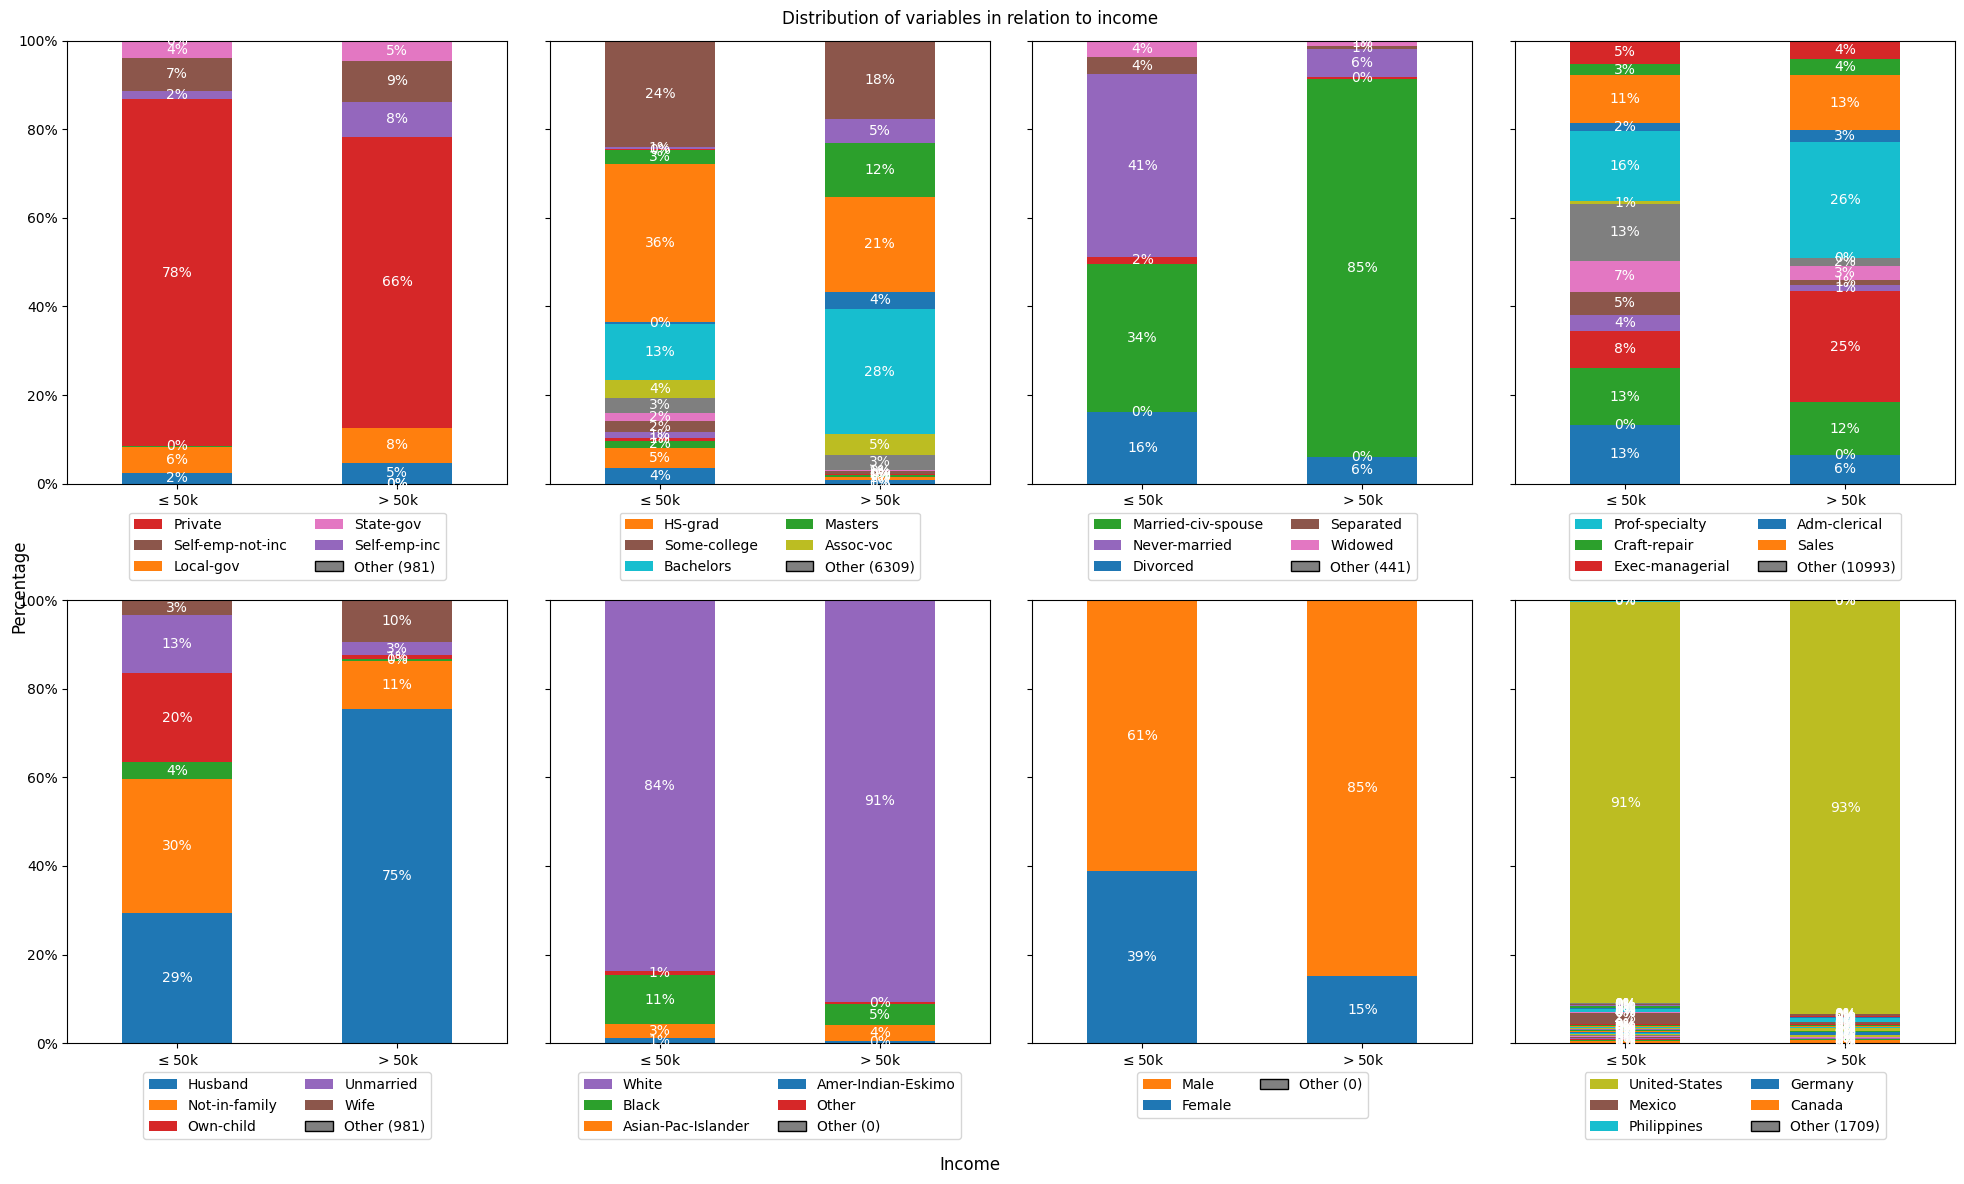

In [13]:
rows=2
cols=4

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols, 6*rows), sharey=True)
fig.suptitle('Distribution of variables in relation to income')
fig.supxlabel('Income')
fig.supylabel('Percentage')

for i, variable in enumerate(categorical):
    row = i // cols
    col = i % cols
    ax = axes[row][col]
    
    ct = pd.crosstab(train_df['income'], train_df[variable])
    ct_pct = ct.apply(lambda r: r/r.sum(), axis=1)

    ct_pct.plot(kind='bar', stacked=True, ax=ax)
    
    ax.set_xticklabels([r'$\leq50$k', r'$>50$k'], rotation=0)
    yticks = mtick.PercentFormatter(1)
    ax.yaxis.set_major_formatter(yticks)
    ax.set_ylim([0, 1])
    ax.set_xlabel('')

    handles, labels = ax.get_legend_handles_labels()
    sorted_labels = sorted(labels, key=lambda x: -ct[x].sum())
    top_labels = sorted_labels[:5]
    remaining_labels = sorted_labels[5:]
    top_handles = [handles[labels.index(l)] for l in top_labels]
    remaining_sum = sum([ct[x].sum() for x in remaining_labels])
    top_labels.append(f'Other ({remaining_sum})')
    top_handles.append(Patch(facecolor='gray', edgecolor='black'))
    ax.legend(top_handles, top_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)


    for i in ax.containers:
        ax.bar_label(i, label_type='center', color="white", fontsize=10, fmt='{:.0%}')

plt.tight_layout()
plt.show()

# Ist der Pairplot nötig was sagt er aus welche insight sehen wir?

In [14]:
# sns.pairplot(train_df, hue='income', corner=True)
# plt.show()

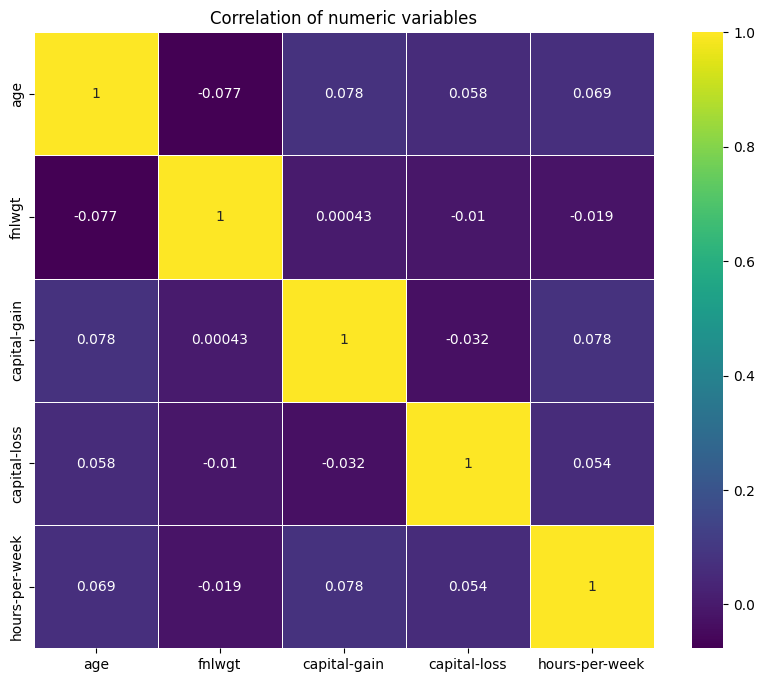

In [15]:
plt.figure(figsize=(10,8),dpi=100)
sns.heatmap(train_df[numeric].corr(),cmap="viridis",modelot=True,linewidth=0.5)
plt.title("Correlation of numeric variables")
plt.show()

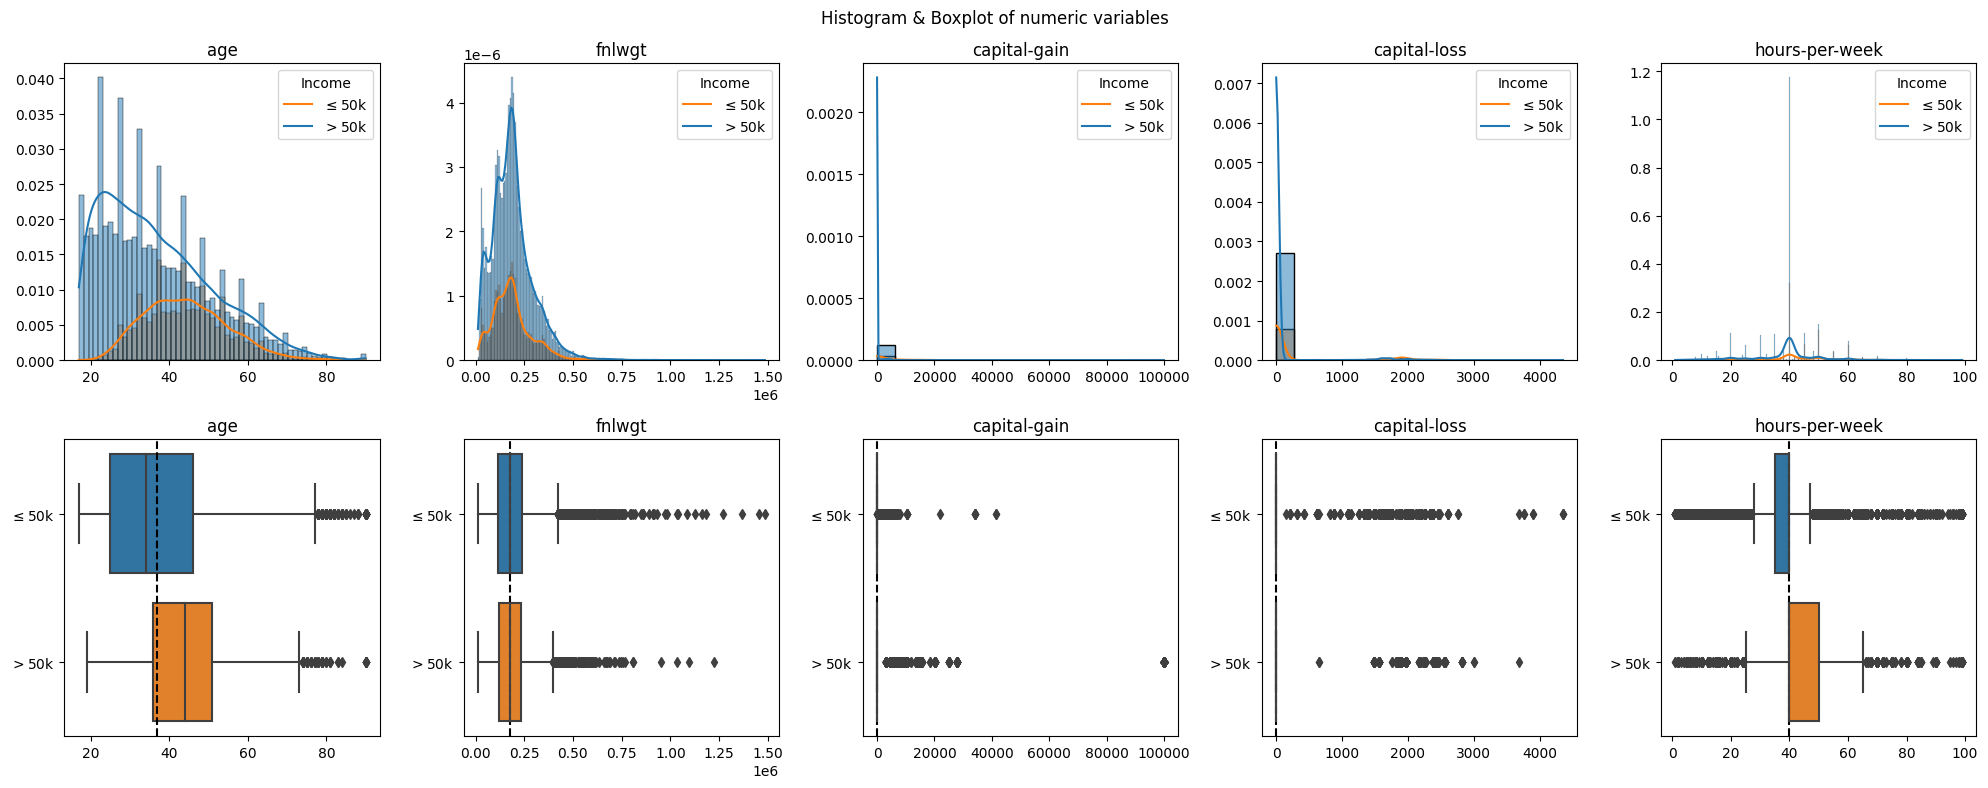

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=len(numeric), figsize=(20, 8))
fig.suptitle("Histogram & Boxplot of numeric variables")

for i, variable in enumerate(numeric):
    sns.histplot(data=train_df, x=variable, hue='income', ax=axes[0][i], kde=True, stat='density')
    sns.boxplot(data=train_df, x=variable, y='income', ax=axes[1][i], orient='h')

    axes[0][i].set_xlabel(None)
    axes[0][i].set_ylabel(None)
    axes[0][i].set_title(variable)
    axes[0][i].legend(title='Income', labels=['$\leq50$k', '$>50$k'])

    axes[1][i].set_xlabel(None)
    axes[1][i].set_ylabel(None)
    axes[1][i].set_title(variable)
    axes[1][i].set_yticklabels(['$\leq50$k', '$>50$k'])

    median = train_df[variable].median()
    axes[1][i].axvline(median, linestyle='--', color='black')
    
plt.tight_layout()
plt.show()

## Results

- We can delete the variable **native-country**. 
- We can encode **sex** to a binary variable
- encode all categorical variables

In [17]:
train_df = train_df.drop('native-country',axis= 1)
test_df = test_df.drop("native-country", axis = 1)
categorical.remove('native-country')

In [18]:
print(f'Train Shape before encoding: {train_df.shape}')
print(f'Test Shape before encoding: {test_df.shape}')

onehot_encoder = ce.OneHotEncoder(cols=categorical)
train_df = onehot_encoder.fit_transform(train_df)
test_df = onehot_encoder.transform(test_df)

print(f'Train Shape after encoding: {train_df.shape}')
print(f'Test Shape after encoding: {test_df.shape}')

train_df.head()

Train Shape before encoding: (32561, 13)
Test Shape before encoding: (16281, 13)
Train Shape after encoding: (32561, 64)
Test Shape after encoding: (16281, 64)


,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,fnlwgt,...,race_2,race_3,race_4,race_5,sex_1,sex_2,capital-gain,capital-loss,hours-per-week,income
0,39,1,0,0,0,0,0,0,0,77516,...,0,0,0,0,1,0,2174,0,40,0
1,50,0,1,0,0,0,0,0,0,83311,...,0,0,0,0,1,0,0,0,13,0
2,38,0,0,1,0,0,0,0,0,215646,...,0,0,0,0,1,0,0,0,40,0
3,53,0,0,1,0,0,0,0,0,234721,...,1,0,0,0,1,0,0,0,40,0
4,28,0,0,1,0,0,0,0,0,338409,...,1,0,0,0,0,1,0,0,40,0


# Principal component analysis (PCA)

### Notizen
Wieso Dimensions Reduktion?
1. Menschen können sich sehr schwer vorstellen wie höhere Dimensionen aussehen / auch schwer zu Visualisieren
2. Man benötigt sehr viel computing power um ML Algorithmen mit vielen Dimensionen zu trainieren
3. ML-Modelle basierend auf sehr vielen Dimensionen werden ungenau

https://setosa.io/ev/principal-component-analysis/
Was ist und macht PCA?

- PCA führt zu einem guten Verständnis der Daten
- Zur Entscheidung wie viele Hauptkomponenten gewählt werden kmodel man sich der erklärten Varianz zu nutze machen. (Proportion of variance explained PVE)
- Sie kmodel auch als Hilfsmittel für das überwachte Lernen vorgeschalten werden
- Vor der PCA sollte man alle Variable skalieren damit Sie alle die Varianz 1 besitzen und somit besser zueinander in Relation stehen

Wie ist das vorgehen bei der PCA?
1. Standardisieren / Skalieren
2. Kovarianzmatrix berechnen
3. Eigenwerte und Eigenvektoren berechnen
4. Egenwerte und -vektoren sortieren (diejenigen mit den höchsten Werten haben die höchste Signifikanz)
5. Transform the original matrix of data by multiplying it top n eigenvectors selected above.

Oder Sklearn PCA



In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

pca_train_df = train_df.drop(['income'], axis=1)
pca_test_df = test_df.drop(['income'], axis=1)
#Nur auf trainingsdaten fitten
pca_train_df_scale = scaler.fit_transform(pca_train_df)
pca_test_df_scale = scaler.fit_transform(pca_test_df)



In [20]:
pca2 = PCA(n_components = 2)
principalComponents = pca2.fit_transform(pca_train_df_scale)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, train_df[['income']]], axis=1)
finalDf.head()

,principal component 1,principal component 2,income
0,-0.729667,0.693474,0
1,2.765114,1.077126,0
2,-0.646557,-0.774678,0
3,1.058490,-1.392537,0
4,-1.325059,1.970121,0


In [21]:
print('\nDescription')
print(finalDf.describe())
print('\nInfo')
print(finalDf.info())



Description
       principal component 1  principal component 2        income
count           3.256100e+04           3.256100e+04  32561.000000
mean            1.518804e-16          -3.343114e-16      0.240810
std             2.118745e+00           1.602892e+00      0.427581
min            -4.413223e+00          -4.318681e+00      0.000000
25%            -1.861394e+00          -1.110679e+00      0.000000
50%            -4.287281e-01          -9.220351e-02      0.000000
75%             2.126997e+00           1.099816e+00      0.000000
max             4.782166e+00           5.721631e+00      1.000000

Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   principal component 1  32561 non-null  float64
 1   principal component 2  32561 non-null  float64
 2   income                 32561 non-null  int64  
dtypes: float64(2),

Text(0, 0.5, 'pc2')

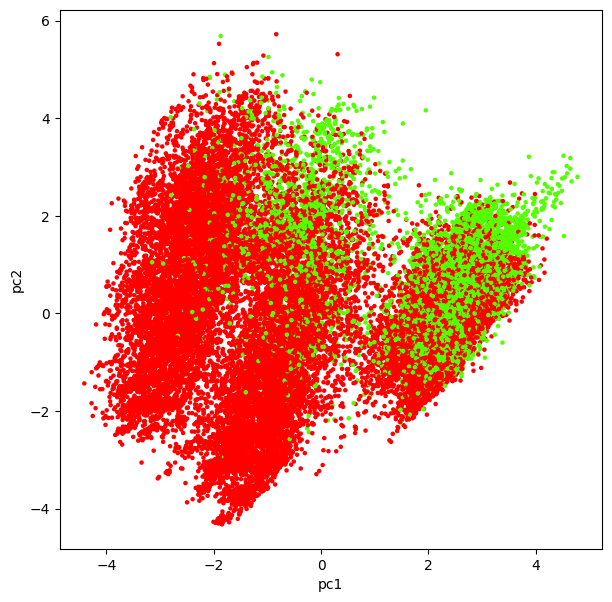

In [22]:
plt.figure(figsize=(7,7))
plt.scatter(finalDf['principal component 1'],finalDf['principal component 2'],c=finalDf['income'],cmap='prism', s =5)
plt.xlabel('pc1')
plt.ylabel('pc2')

In [23]:
#n von pca ist immer die anzahl an variablen
pca = PCA(n_components = 63)

principalComponents = pca.fit_transform(pca_train_df_scale)   

# principalComponents = pca.fit(pca_train_df_scale)



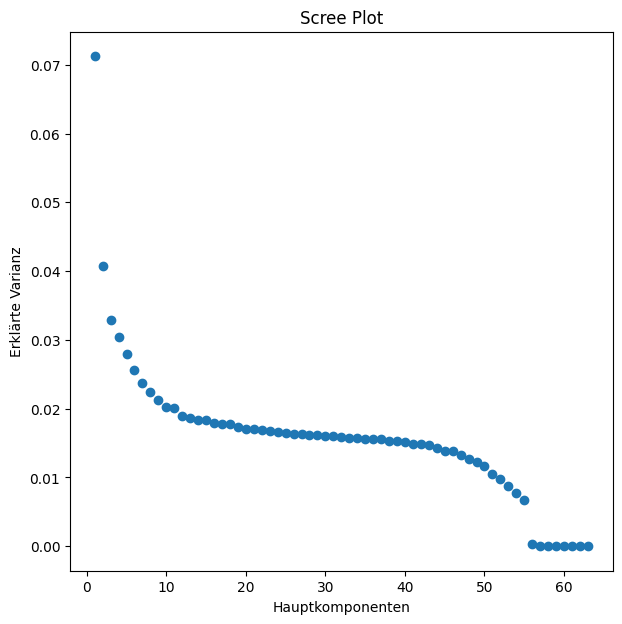

In [24]:
plt.figure(figsize=(7,7))
PC_values = np.arange(pca.n_components_) + 1
plt.scatter(PC_values, pca.explained_variance_ratio_)

plt.title('Scree Plot')
plt.xlabel('Hauptkomponenten')
plt.ylabel('Erklärte Varianz')
plt.show()


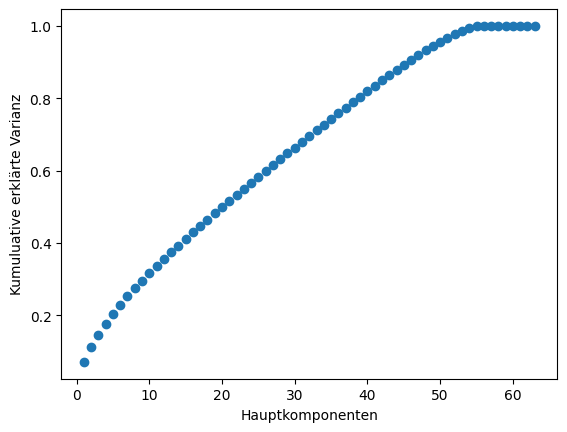

In [25]:
plt.xlabel('Hauptkomponenten')
plt.ylabel('Kumuluative erklärte Varianz')
plt.scatter(PC_values, np.cumsum(pca.explained_variance_ratio_))
plt.show()

## Würde sagen ca 39 - 40 Hauptkomponenten erklären 80 % der Varianz

In [26]:
pca_new = PCA(n_components=45)
pca_new.fit_transform(pca_train_df_scale)

array([[-0.72956103,  0.68504864, -2.77622821, ...,  0.11523794,
         0.03653458,  1.32973779],
       [ 2.76493175,  1.07899724, -1.30681782, ...,  0.82007296,
         0.26150377, -1.63209832],
       [-0.64651922, -0.7815467 ,  0.61039302, ..., -0.21313552,
         0.16014849, -0.30470182],
       ...,
       [-2.27962759,  3.00832287,  2.01575058, ...,  1.30855269,
         1.51244317,  0.51042055],
       [-1.83247471, -2.54895069, -0.47815165, ..., -0.22195283,
        -0.11966184,  0.13982822],
       [ 0.78974238,  3.19651757, -0.53515828, ..., -1.37093811,
         1.73638458,  0.48669015]])

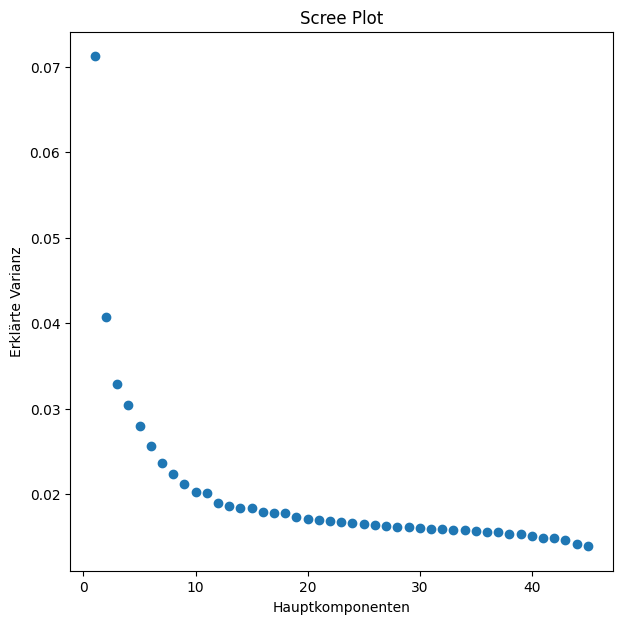

In [27]:
plt.figure(figsize=(7,7))
PC_values = np.arange(pca_new.n_components_) + 1
plt.scatter(PC_values, pca_new.explained_variance_ratio_)

plt.title('Scree Plot')
plt.xlabel('Hauptkomponenten')
plt.ylabel('Erklärte Varianz')
plt.show()

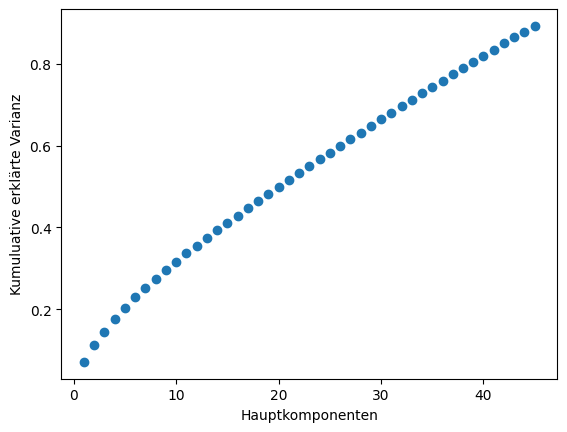

In [28]:
plt.xlabel('Hauptkomponenten')
plt.ylabel('Kumuluative erklärte Varianz')
plt.scatter(PC_values, np.cumsum(pca_new.explained_variance_ratio_))
plt.show()

# Cluster Analyse

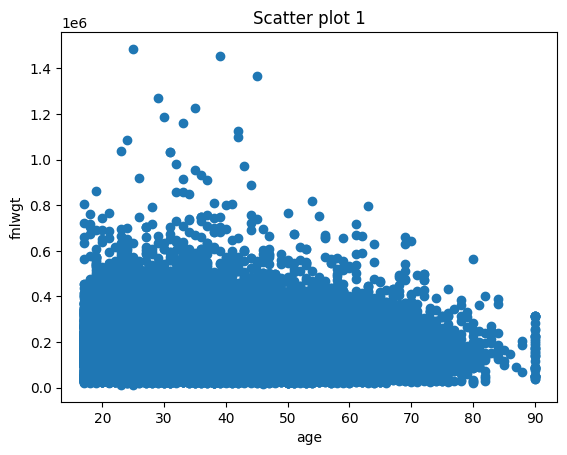

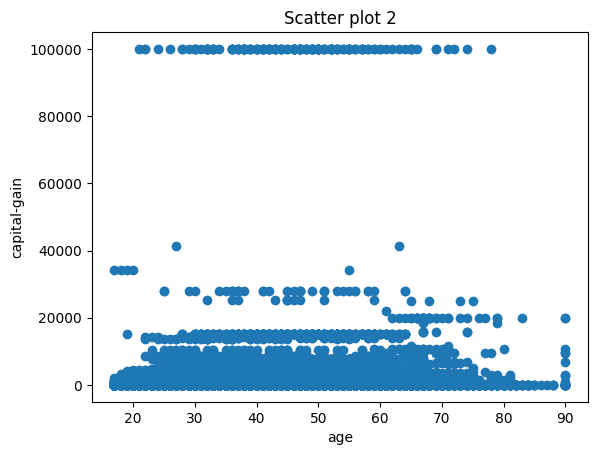

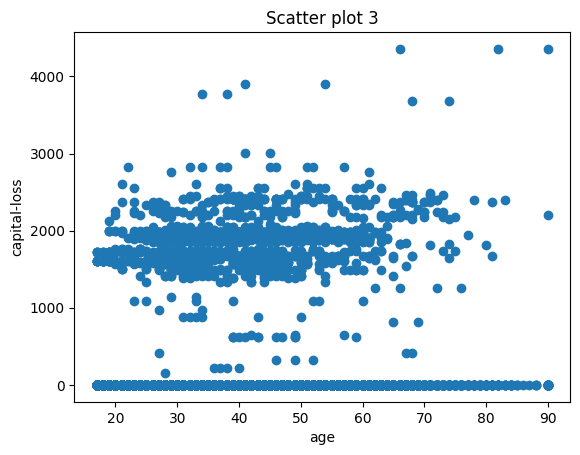

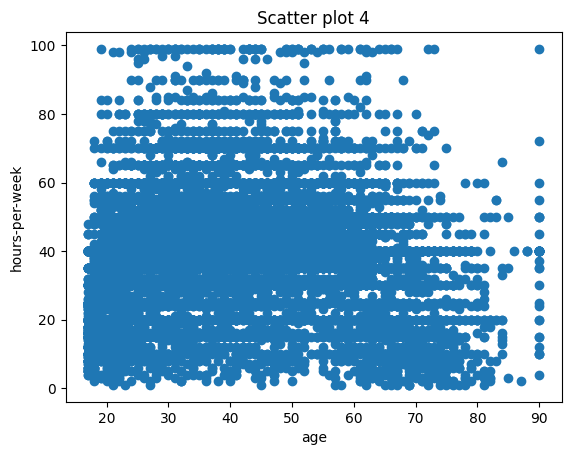

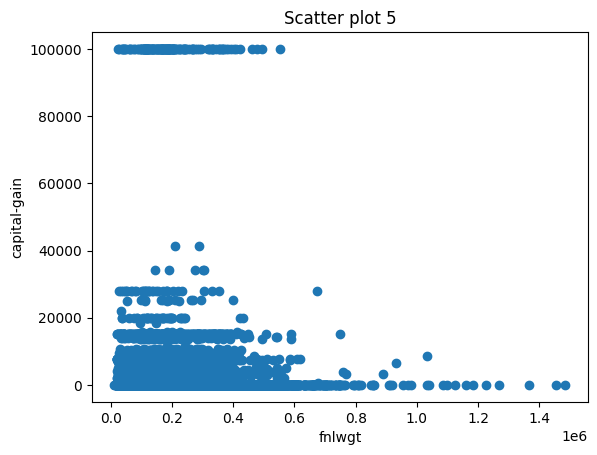

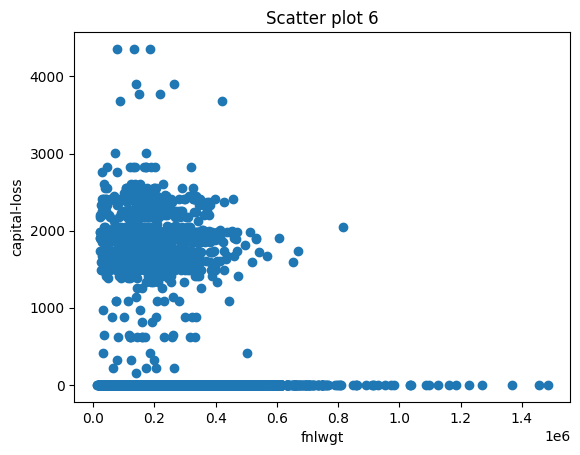

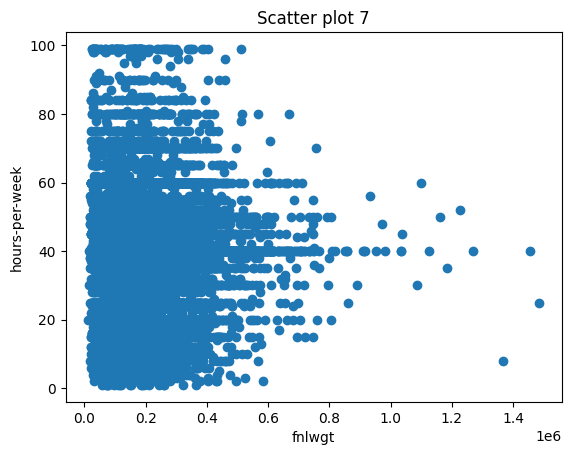

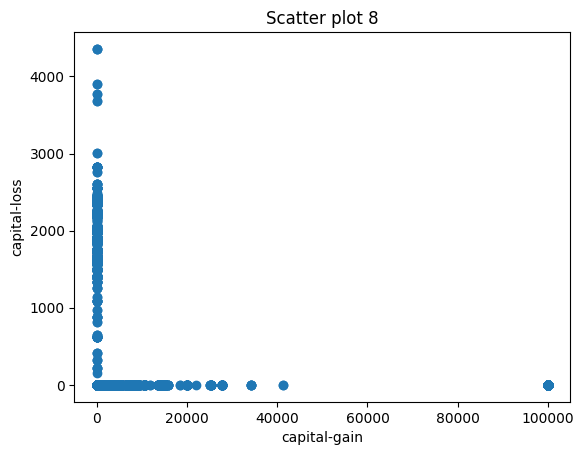

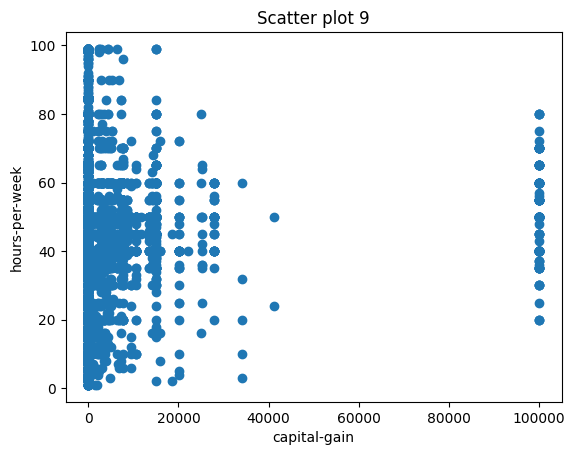

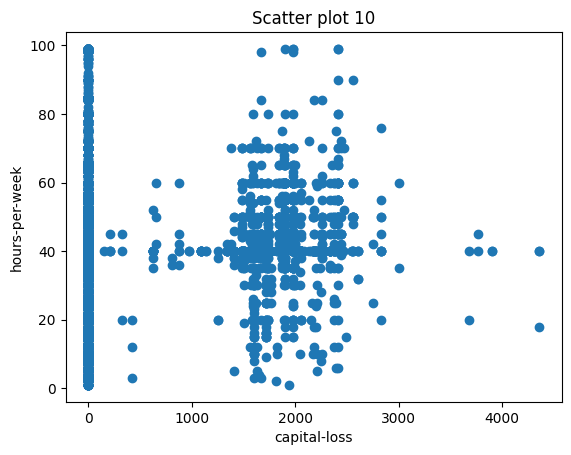

In [44]:


#select the pair you want to plot

"""There are 5 categorical variables:

workclass contains 8 labels
education contains 16 labels
marital-status contains 7 labels
occupation contains 14 labels
relationship contains 6 labels
race contains 5 labels
sex contains 2 labels
native-country contains 41 labels

There are 5 numeric variables:

['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']
"""


data_list = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']


count = 1
for i in range(0,len(data_list)):
    data1 = data_list[i]

    for j in range(i+1, len(data_list)):

        data2 = data_list[j]

        X = train_df[[data1, data2]]

        plt.figure(count)
        scatter_plot = plt.scatter(train_df[data1], train_df[data2])   
        plt.xlabel(data1)
        plt.ylabel(data2)
        plt.title('Scatter plot %i' %count)
        count+=1


plt.show()


c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivar

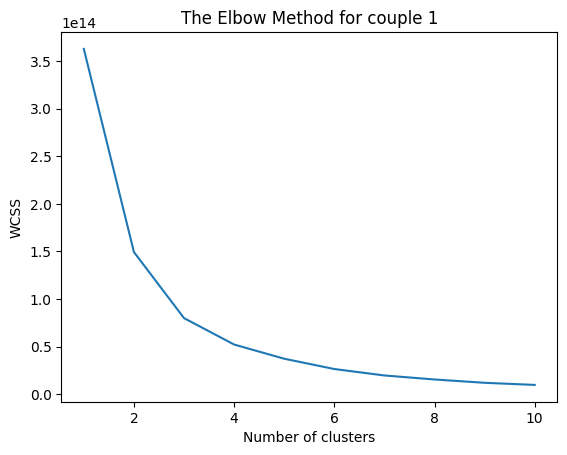

c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivar

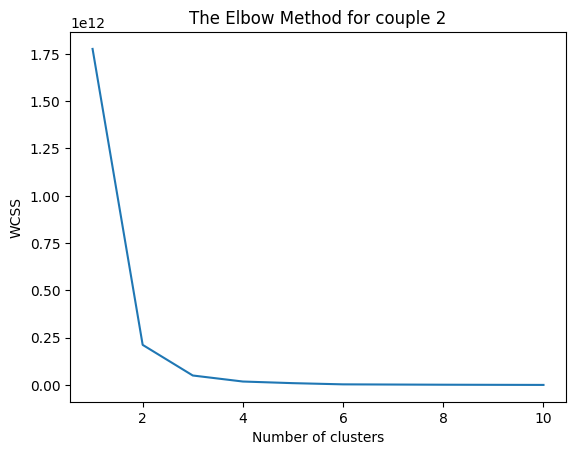

c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivar

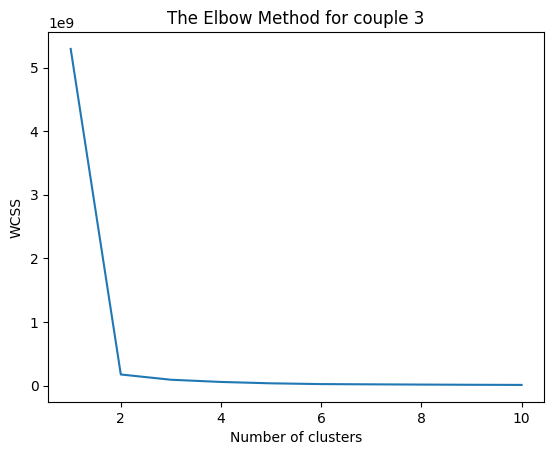

c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivar

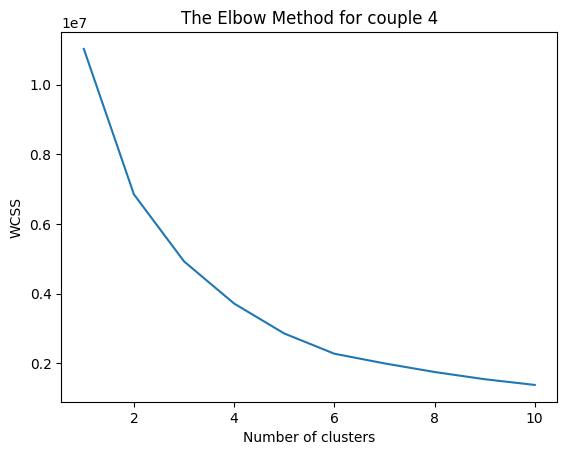

c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivar

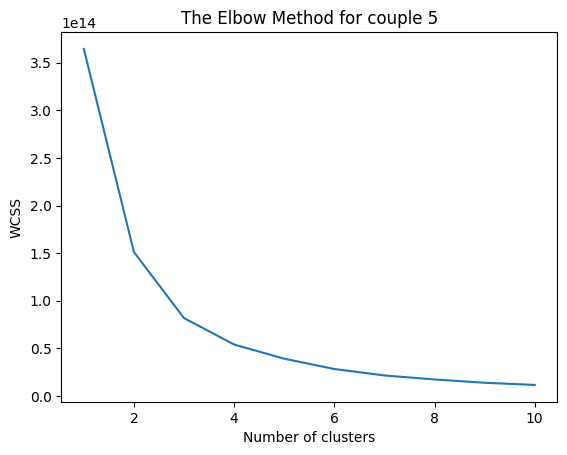

c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivar

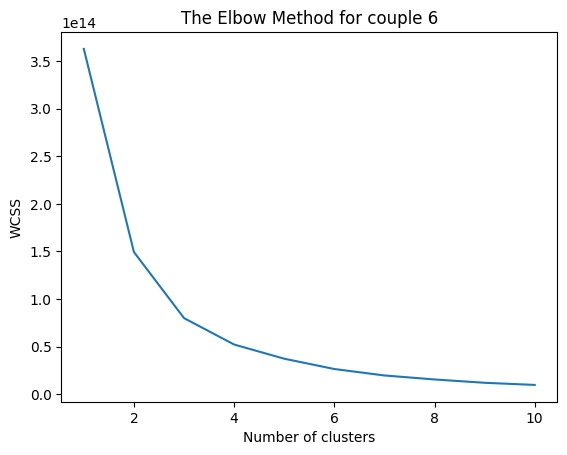

c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivar

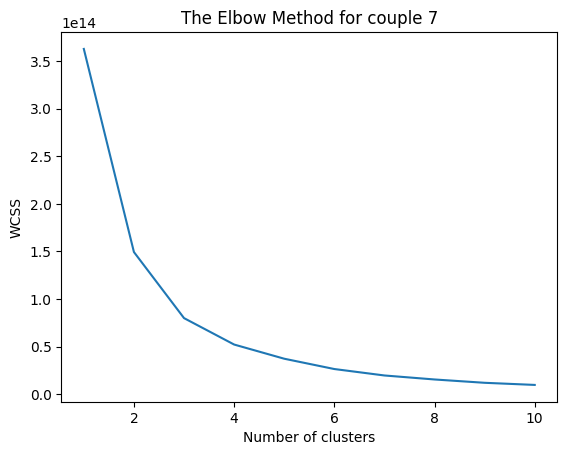

c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivar

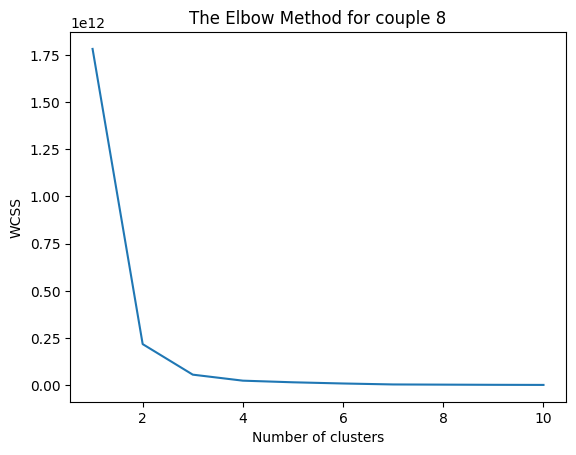

c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivar

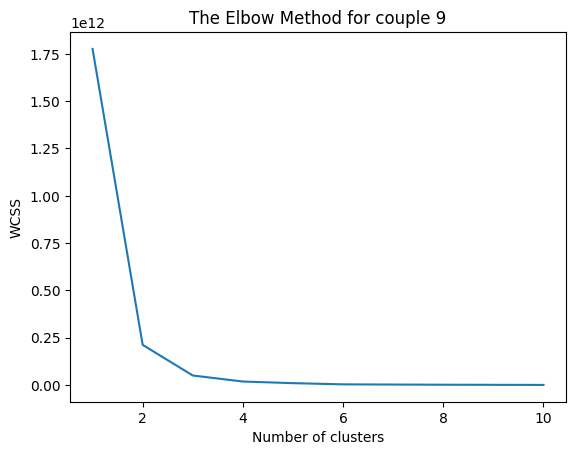

c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivar

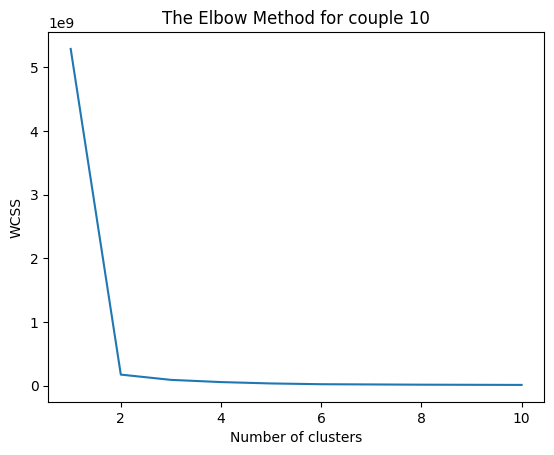

In [47]:
def kmeans_kvalues_plot(X,count):
  wcss = [] # the sum of the squared distance between each point and the centroid in a cluster
  for i in range(1, 11):
      kmeans = KMeans(n_clusters=i, init = 'k-means++', random_state = 42)
      kmeans.fit(X)
      wcss.append(kmeans.inertia_)

      
  plt.plot(range(1, 11), wcss)
  plt.title(f'The Elbow Method for couple {count}' )
  plt.xlabel('Number of clusters')
  plt.ylabel('WCSS')
  plt.show()





count = 1
for i in range(0,len(data_list)):
    data1 = data_list[i]

    for j in range(i+1, len(data_list)):

        data2 = data_list[j]

        X = train_df[[data1, data2]]

        plt.figure(count)
        kmeans_kvalues_plot(X,count)
        
        count+=1
  

c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivar

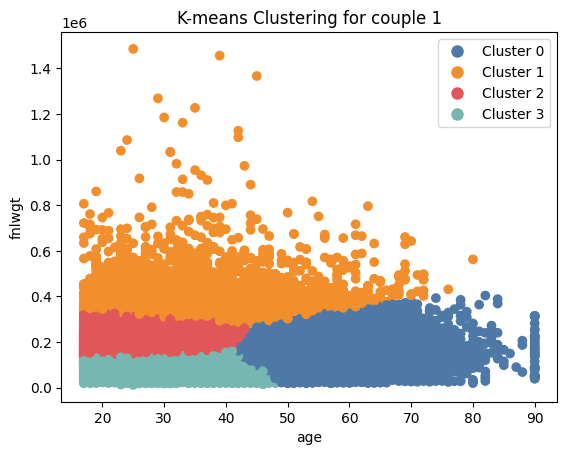

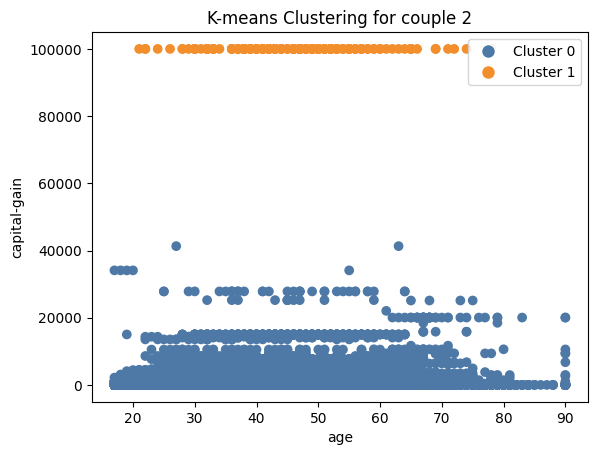

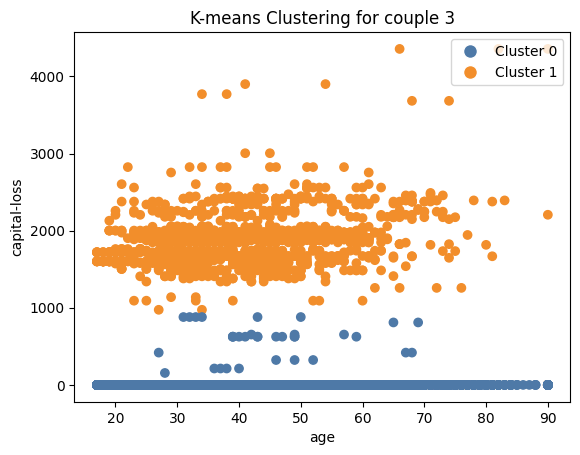

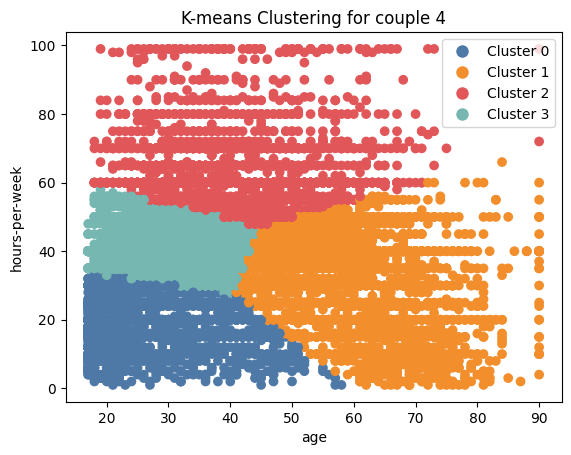

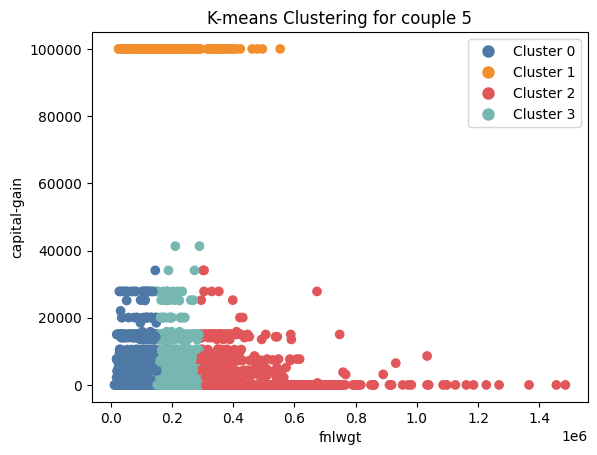

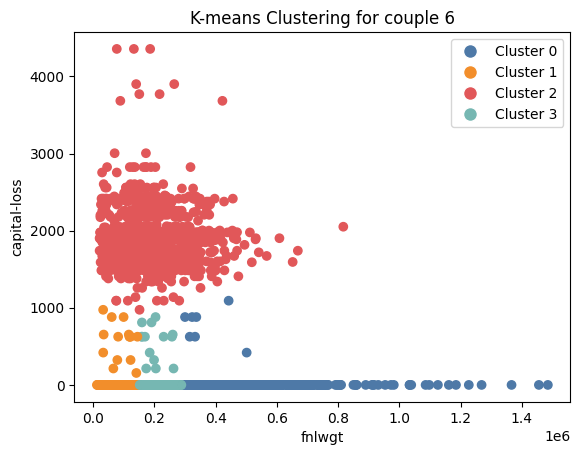

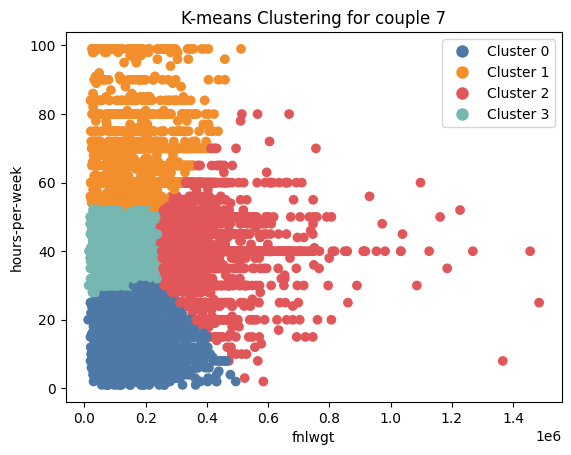

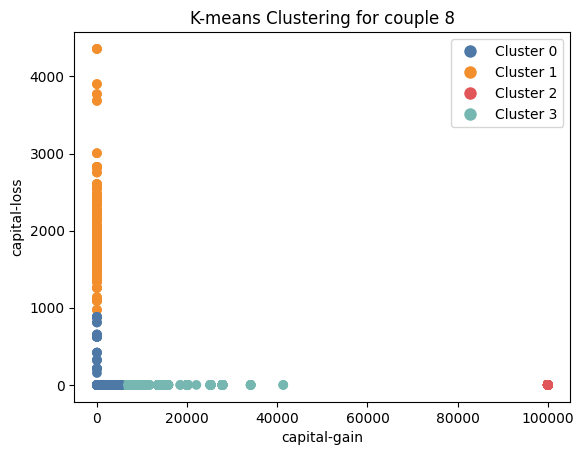

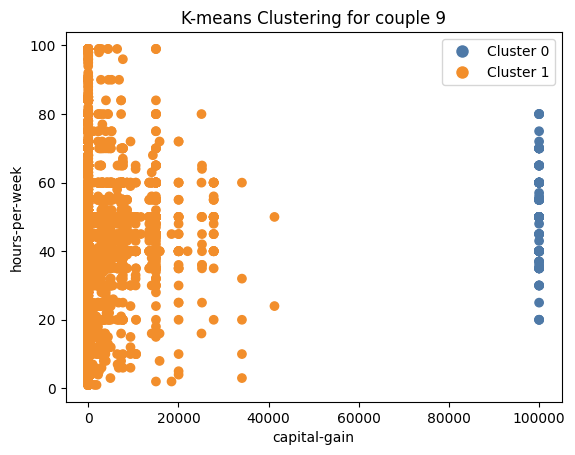

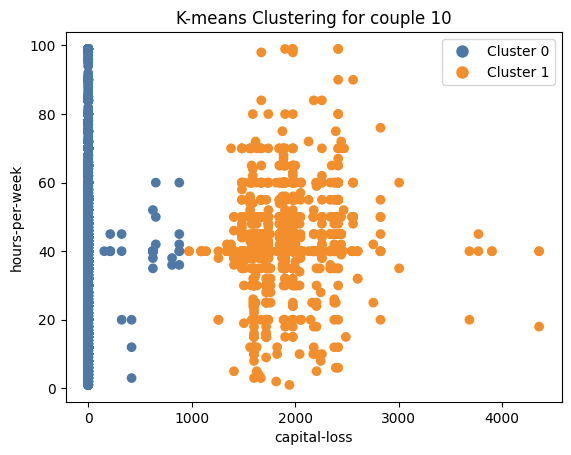

In [48]:
def kmeans_method(X, n_clusters):
  # Standardize the independent variables
  scaler = StandardScaler()
  X = scaler.fit_transform(X)
  kmeans = KMeans(n_clusters = n_clusters, init = 'k-means++', random_state = 42)
  y_kmeans = kmeans.fit_predict(X)
  
  return kmeans, y_kmeans

#you can twist this value
color_list = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f', '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

bounds_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


n_clusters_values = [4,2,2,4,4,4,4,4,2,2]

count = 1
for i in range(0,len(data_list)):
    data1 = data_list[i]

    for j in range(i+1, len(data_list)):

        data2 = data_list[j]

        X = train_df[[data1, data2]]
        color_list_seg = color_list[0:n_clusters_values[count-1]]
        bounds_list_seg = bounds_list[0:n_clusters_values[count-1]]

        cmap = ListedColormap(color_list_seg)
        norm = plt.Normalize(vmin=0, vmax=n_clusters_values[count-1])

        kmeans, y_kmeans = kmeans_method(X, n_clusters_values[count-1])
        X = X.values
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_

        plt.figure(count)
        scatter_plot = plt.scatter(train_df[data1], train_df[data2], c=labels,cmap=cmap, norm=norm)   #labels
        plt.xlabel(data1)
        plt.ylabel(data2)
        plt.title('K-means Clustering for couple %i' %count)

        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i), markerfacecolor=c, markersize=10) for i, c in enumerate(cmap.colors)]
        plt.legend(handles=legend_elements, loc='upper right')        
        
        count+=1

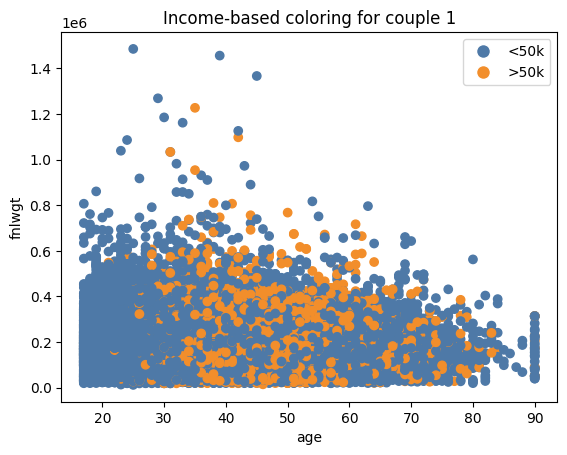

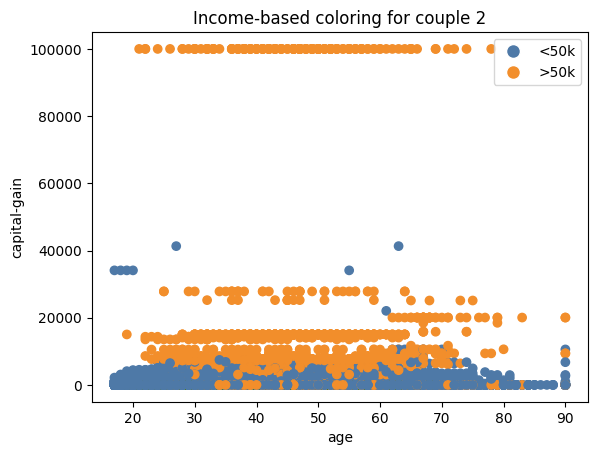

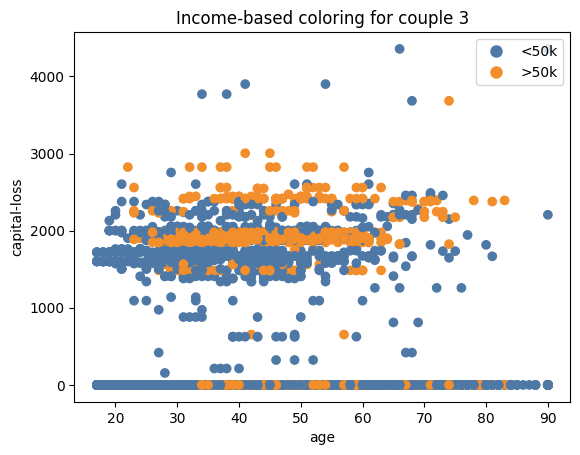

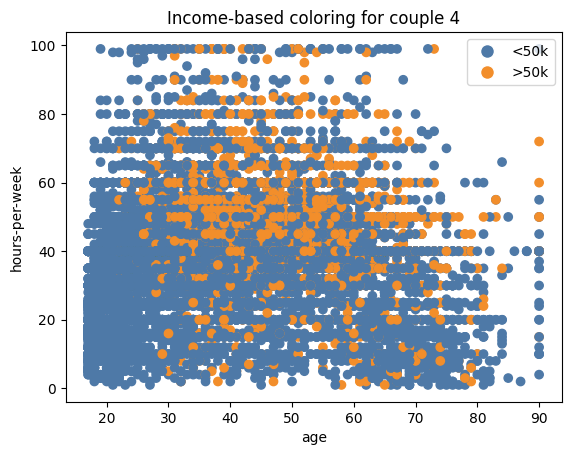

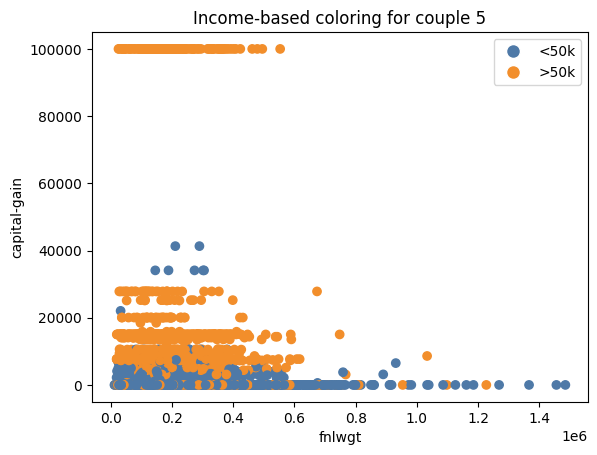

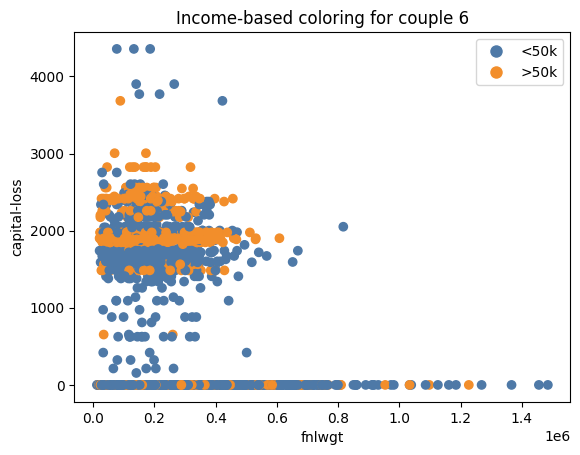

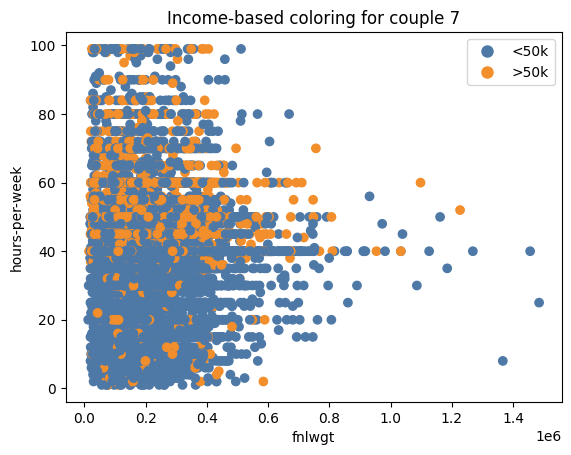

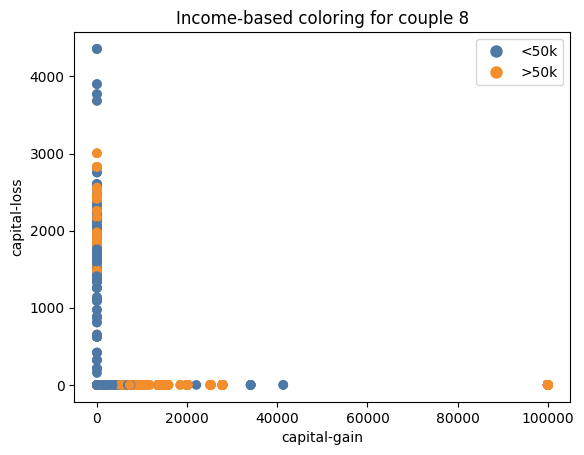

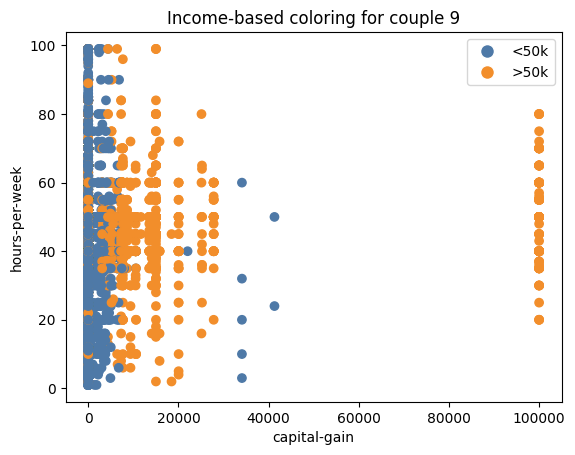

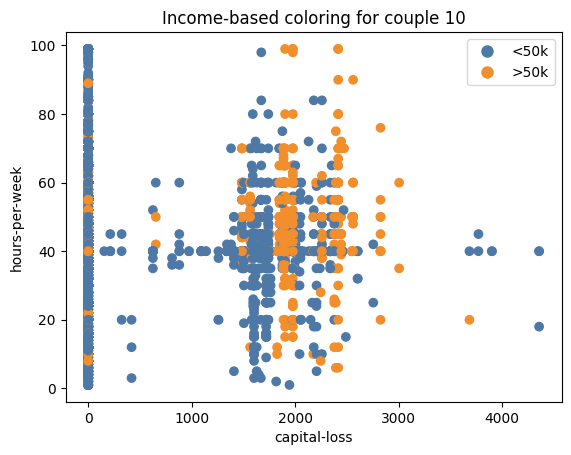

In [49]:

count = 1
for i in range(0,len(data_list)):
    data1 = data_list[i]

    for j in range(i+1, len(data_list)):

        data2 = data_list[j]

        X = train_df[[data1, data2]]

        plt.figure(count)
        
        
        scatter_plot = plt.scatter(train_df[data1], train_df[data2], c=train_df['income'],cmap=cmap, norm=norm)
        plt.xlabel(data1)
        plt.ylabel(data2)
        cmap = ListedColormap(['#4e79a7', '#f28e2b'])
        bounds = [0, 1, 2]
        norm = plt.Normalize(vmin=0, vmax=2)
        income_legends = ['<50k',">50k"]
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=income_legends[i], markerfacecolor=c, markersize=10) for i, c in enumerate(cmap.colors)]
        plt.legend(handles=legend_elements, loc='upper right')
        plt.title('Income-based coloring for couple %i' %count) 
        count+=1


# Final Data 

In [29]:
X_train = train_df.drop(["income"],axis=1)
Y_train = train_df['income']

X_test = test_df.drop(["income"],axis=1)
Y_test = test_df['income']

scaler_logit = StandardScaler()

# #Nur auf trainingsdaten fitten
x_train_scale = scaler_logit.fit(X_train)

x_train_scale = pd.DataFrame(scaler_logit.transform(X_train), columns=X_train.columns)
x_test_scale = pd.DataFrame(scaler_logit.transform(X_test), columns=X_test.columns)



# Logit-Modell

In [30]:

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train_scale,Y_train)

y_train_hat =logisticRegr.predict(x_train_scale)
train_accuracy = accuracy_score(Y_train, y_train_hat)*100
print('"Accuracy for our Training dataset without PCA is: %.4f %%' % train_accuracy)


"Accuracy for our Training dataset without PCA is: 85.1080 %


In [31]:
y_test_hat = logisticRegr.predict(x_test_scale)
test_accuracy = accuracy_score(Y_test, y_test_hat)*100
print('"Accuracy for our Test dataset without PCA is: %.4f %%' % test_accuracy)

"Accuracy for our Test dataset without PCA is: 85.0009 %


### With PCA reduction


In [32]:
x_pca_train = pca_new.fit_transform(pca_train_df_scale)
x_pca_test = pca_new.fit_transform(pca_test_df_scale)

x_pca_train = pd.DataFrame(x_pca_train)

logit = LogisticRegression()
logit.fit(x_pca_train,Y_train)


LogisticRegression()

In [33]:
y_pca_test_hat = logit.predict(x_pca_test)
test_accuracy = accuracy_score(Y_test, y_pca_test_hat)*100
print('"Accuracy for our Test dataset with PCA is: %.4f %%' % test_accuracy)

"Accuracy for our Test dataset with PCA is: 76.9117 %


### Vielleicht hier nochmal Parameter Tuning machen mit einem for loop bei verschiedenen n

# Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier as rfc
forest = rfc()
forest.fit(x_train_scale,Y_train)


RandomForestClassifier()

In [35]:
y_rfc_hat = forest.predict(x_train_scale)

In [36]:
print(forest.score(x_train_scale,Y_train))
print(forest.score(x_test_scale,Y_test))

0.9999692884125181
0.8494564215957251


In [37]:
pd.DataFrame(forest.feature_importances_, index=x_train_scale.columns).sort_values(by=0, ascending=False)

,0
fnlwgt,0.173957
age,0.160278
capital-gain,0.105572
hours-per-week,0.089292
marital-status_2,0.060844
...,...
education_15,0.000190
occupation_14,0.000144
workclass_7,0.000071
occupation_13,0.000034


### Tuning


In [38]:
forest_2 = rfc(n_estimators=1000)
forest_2.fit(x_train_scale,Y_train)

RandomForestClassifier(n_estimators=1000)

In [39]:
y_rfc_hat_2 = forest_2.predict(x_train_scale)

In [40]:
print(forest_2.score(x_train_scale,Y_train))
print(forest_2.score(x_test_scale,Y_test))

0.9999692884125181
0.8510533750998096


In [50]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [ 30, 40]
}
forest_tuned = rfc()


# Instantiate the grid search model
grid_search = GridSearchCV(estimator = forest_tuned, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [69]:
'''

Muss nochmal verbessert werden bitte nicht löschen!

'''
# # Fit the grid search to the data
# grid_search.fit(x_pca_train, Y_train)
# grid_search.best_params_
# {'bootstrap': True,
#  'max_depth': 80,
#  'max_features': 3,
#  'min_samples_leaf': 5,
#  'min_samples_split': 12,
#  'n_estimators': 100}
# best_grid = grid_search.best_estimator_
# # grid_accuracy = evaluate(best_grid, x_pca_test, Y_test)
# # improvement =  100 * (grid_accuracy - base_accuracy) / base_accuracy
# # print('Improvement of {:0.2f}%.'.format(improvement))

Fitting 3 folds for each of 144 candidates, totalling 432 fits


# Neuronal Networks

In [65]:

model = tf.keras.models.Sequential() # Initializing
model.add(tf.keras.layers.Dense(units=64, activation='relu')) # input and 1st hidden layer
model.add(tf.keras.layers.Dense(units=64, activation='relu')) # 2nd hidden layer
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid')) # output layer
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) # compiling, there are couple of methods
history = model.fit(x_train_scale, Y_train, batch_size = 32, epochs = 200)



Epoch 1/200
1018/1018 [==============================] - 2s 2ms/step - loss: 0.3424 - accuracy: 0.8404
Epoch 2/200
1018/1018 [==============================] - 2s 2ms/step - loss: 0.3110 - accuracy: 0.8557
Epoch 3/200
1018/1018 [==============================] - 2s 2ms/step - loss: 0.3040 - accuracy: 0.8584
Epoch 4/200
1018/1018 [==============================] - 2s 2ms/step - loss: 0.2997 - accuracy: 0.8602
Epoch 5/200
1018/1018 [==============================] - 2s 2ms/step - loss: 0.2956 - accuracy: 0.8635
Epoch 6/200
1018/1018 [==============================] - 2s 2ms/step - loss: 0.2936 - accuracy: 0.8650
Epoch 7/200
1018/1018 [==============================] - 2s 2ms/step - loss: 0.2900 - accuracy: 0.8666
Epoch 8/200
1018/1018 [==============================] - 2s 2ms/step - loss: 0.2884 - accuracy: 0.8672
Epoch 9/200
1018/1018 [==============================] - 2s 2ms/step - loss: 0.2853 - accuracy: 0.8664
Epoch 10/200
1018/1018 [==============================] - 2s 2ms/step - l

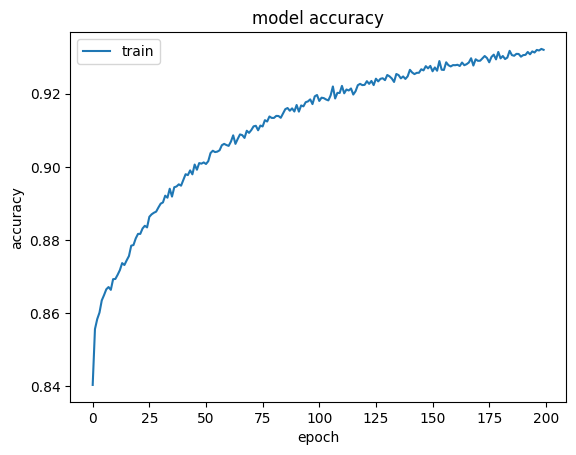

In [66]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

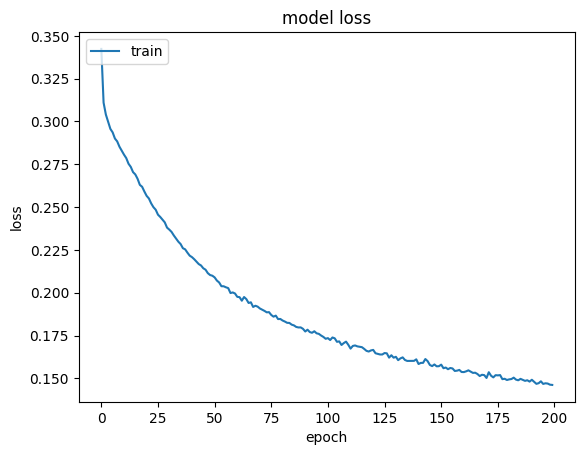

In [67]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()